In [88]:
import scipy
import random
import portpy.photon as pp
from skimage import measure
import numpy as np
from cvxpy import *
from scipy import sparse
import sklearn.metrics
import cProfile
import time
import sys
import psutil
import cvxpy as cp
from scipy.linalg import LinAlgError
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
import scipy.sparse



In [21]:

data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
structs.create_opt_structures(opt_params)
inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)
plan_sparse = pp.Plan(ct, structs, beams, inf_matrix_sparse, clinical_criteria)
opt = pp.Optimization(plan_sparse, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_sparse = opt.solve(solver='MOSEK', verbose=True)
dose_sparse_1d = plan_sparse.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions())
x_sparse =sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions()

beams_dense = pp.Beams(data, load_inf_matrix_full=True)
inf_matrix_dense = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_dense, is_full=True)
plan_dense = pp.Plan(ct, structs, beams, inf_matrix_dense, clinical_criteria)
dose_dense_1d = plan_dense.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_dense.get_num_of_fractions())
A_dense = plan_dense.inf_matrix.A
# sparse_tol = plan_sparse.inf_matrix.sparse_tol
#print(sol_sparse['problem_value'])


creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Sep 11 01:32:33 PM: Your problem has 1946 variables, 110663 constraints, and 0 parameters.
(CVXPY) Sep 11 01:32:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 11 01:32:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 11 01:32:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 11 01:32:33 PM: Your problem is compiled with the CPP canonicalization backend.
------------------------------------

In [7]:

def importance_sampling(A_dense, c):
    m, n = A_dense.shape
    B = np.zeros((m, c))
    
    # Calculate the Probability p for each Column
    p = np.sum(A_dense, axis=0) / np.sum(A_dense)
    
    for j in range(c):
        # Select column i with probability p_i
        i = np.random.choice(n, p=p)
       # Add and scale the selected column
        B[:, j] = A_dense[:, i] / (c * p[i])
    
    return B


In [9]:
# HyperParameter
c = 400

start_time = time.time()
result = importance_sampling(A_dense, c)
end_time = time.time()


print(result)
total_execution_time = end_time - start_time
print(f" Matrix Build Runtime : {total_execution_time} Second")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 Matrix Build Runtime : 0.32340025901794434 Second


In [11]:
import pandas as pd

df_S = pd.DataFrame(result.T)
df_S

,0,1,2,3,4,5,6,7,8,9,...,60173,60174,60175,60176,60177,60178,60179,60180,60181,60182
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_A_dense = pd.DataFrame(A_dense)
df_A_dense

,0,1,2,3,4,5,6,7,8,9,...,532,533,534,535,536,537,538,539,540,541
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
S = result.T
A = A_dense
p = dose_dense_1d
print(f'S = {S.shape}\nA = {A_dense.shape}\np = {p.shape}')

S = (400, 60183)
A = (60183, 542)
p = (60183,)


In [27]:
df_dose = pd.DataFrame(p)
df_dose

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
60178,0.0
60179,0.0
60180,0.0
60181,0.0


In [31]:
df_S.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 60183 entries, 0 to 60182
dtypes: float64(60183)
memory usage: 183.7 MB


In [33]:
df_S.describe()

,0,1,2,3,4,5,6,7,8,9,...,60173,60174,60175,60176,60177,60178,60179,60180,60181,60182
count,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,...,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
start_time = time.time()

sol_ls_S = scipy.sparse.linalg.lsqr(S @ A, S @ p )
    
end_time = time.time()
total_execution_time = end_time - start_time
print(f"LS solution time: {total_execution_time} Second")


LS solution time: 0.453507661819458 Second


In [39]:
x_sampling = sol_ls_S[0]
cost = sum_squares(S @ A @ x_sampling - S @ p)
prob = Problem(Minimize(cost))
sol = prob.solve(solver='MOSEK', verbose=False)
sol

0.12191702978972609

<br><center> ***Minimize*** $\lVert SAx - Sp\rVert_{2}^2$

  

In [42]:
opt = pp.Optimization(plan_full, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_dense = opt.solve(solver='MOSEK', verbose=False)

x_dense = sol_dense['optimal_intensity'] * plan_full.get_num_of_fractions()

Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done


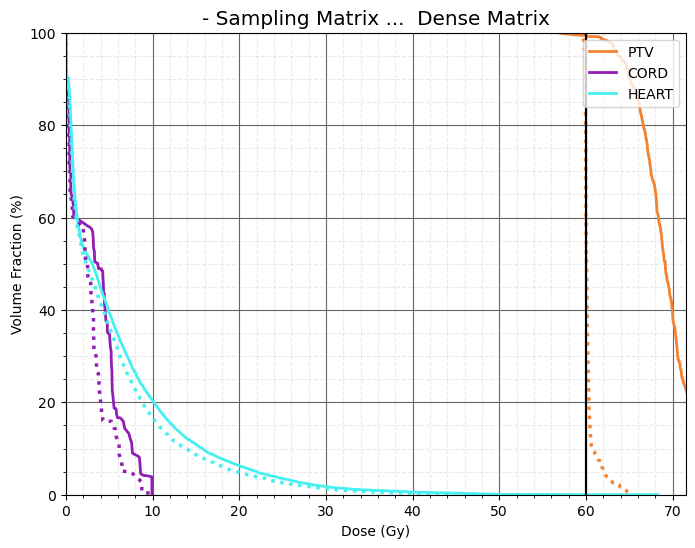

Done!


In [43]:
# DVH Plot
dose_dense = plan_full.inf_matrix.A @ x_dense
dose_sampling = plan_full.inf_matrix.A @ x_sampling 

fig, ax = plt.subplots(figsize=(8, 6))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
ax = pp.Visualization.plot_dvh(plan_full, dose_1d= dose_sampling, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_dense, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('- Sampling Matrix ...  Dense Matrix')
plt.savefig('DVH_Sampling.png')
plt.show()
print('Done!')

In [44]:
print("Data Type:", dose_sampling.dtype)

print("Shape:", dose_sampling.shape)


Data Type: float64
Shape: (60183,)


In [48]:

# Convert ndarray to DataFrame
dose_sampling_df = pd.DataFrame(dose_sampling)

# Describe
description = dose_sampling_df.describe()

print(description)


                  0
count  60183.000000
mean       6.438242
std       12.097644
min       -0.197831
25%        0.339094
50%        1.302521
75%        6.428319
max       87.837931


In [50]:
##  Analysis of matrix sparsity

is_sparse = sparse.issparse(S)
is_sparse

False

In [52]:
x_sampling = sol_ls_S[0]
print(f'x :\t {x_sampling[0:6]}')

x :	 [3.79432934 2.53839366 2.52239716 3.01051603 8.31570728 8.64002621]


In [56]:
sol_ls_A_Dense = scipy.sparse.linalg.lsqr(A_dense,dose_sparse_1d)
x_A_dense = sol_ls_A_Dense[0]

relative_error = np.linalg.norm(x_A_dense - x_sampling) / np.linalg.norm(x_A_dense)
print(f'Relative Error:', relative_error)


Relative Error: 0.4114988653250975


In [58]:
x_A_dense= sol_ls_A_Dense[0]
print(f'x_A_dense :\t {x_A_dense[0:6]}')

cost = cp.sum_squares((A_dense @ x_A_dense  - A_dense @ x_sampling  )/ cp.norm(A_dense @ x_A_dense))
prob = cp.Problem(Minimize(cost))
sol = prob.solve(solver='MOSEK', verbose=False)
sol

x_A_dense :	 [ 3.67488051 -1.8787341  -1.95530416 -2.43994502 12.06894575  5.92360281]


0.04351693896908733

In [60]:
# Norm Frobenius

cost = cp.norm(A_dense @ x_A_dense - A_dense @ x_sampling, "fro")/ cp.norm(A_dense @ x_A_dense, "fro")

prob = cp.Problem(cp.Minimize(cost))

prob.solve()


0.2086071402639117

In [62]:
m,n = A_dense.shape
d = m*n
a,b = S.shape
r = a*b
t,v = (S @ A).shape
f = t*v
nonzero_count = np.count_nonzero(A_dense)/d
print("nnz A Matrix: ", nonzero_count)
num_non_zero = np.count_nonzero(S @ A)/f
print("nnz SA Matrix :", num_non_zero)
nnz_S = np.count_nonzero(S )/r
print("nnz S Matrix :", nnz_S)

nnz A Matrix:  0.3151234981768092
nnz SA Matrix : 1.0
nnz S Matrix : 0.3258785703604008


In [66]:
cost = cp.sum_squares(( A_dense @ x_sampling -p )/ cp.norm(p))
prob = cp.Problem(Minimize(cost))
prob.solve()

0.01281153251938267

In [68]:
## MSE 

d_true = p          # Real Dose 
d_pred = A_dense @ x_sampling   # Predicted Dose  

MSE1 = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE1)


Mean Squared Error : 2.4538995458752484


In [70]:
## MSE 

d_true = A_dense @ x_A_dense            # Real Dose 
d_pred = A_dense @ x_sampling   # Predicted Dose  

MSE2 = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE2)
 

Mean Squared Error : 6.155900084982141


In [72]:
r1 = np.linalg.matrix_rank(S @ A_dense) 
r2 = np.linalg.matrix_rank(A_dense)      
print( f'Rank approximation matrix = {r1}\n Rank  Dense matrix = {r2}')

Rank approximation matrix = 278
 Rank  Dense matrix = 542


In [74]:
memory_usage_sol_ls_S = sys.getsizeof(sol_ls_S )
megabyte_size_sol_ls_S = memory_usage_sol_ls_S / 1024 / 1024

print(f"Memory sol_ls_S:  {megabyte_size_sol_ls_S} MB")

Memory sol_ls_S:  0.00011444091796875 MB


In [76]:
memory_usage_S = sys.getsizeof(S)
megabyte_size_S = memory_usage_S / 1024 / 1024

print(f"Memory S : {megabyte_size_S} MB")

Memory S : 0.0001220703125 MB


In [82]:
import numpy as np

def calculate_absolute_error(vector1, vector2):
    array1 = np.array(x_A_dense)
    array2 = np.array(x_sampling)

    absolute_error = np.linalg.norm(array1 - array2, ord=1) 

    return absolute_error


error = calculate_absolute_error(x_A_dense, x_sampling)
print(f"Absolute Error: {error}")


Absolute Error: 1219.940055153231


<center> 
Minimize $\lVert SAx - Sp \rVert_{2}^2$
</center>
<center>
subject to $x \succeq 0$
</center>
<center>
p = دوزتجویزی
</center>


In [90]:
start_time = time.time()

# Solving the LS Problem with  Constant - x>=0
sol_sparse_con = lsq_linear (S @ A ,  S @ p, bounds=(0, np.inf))

end_time = time.time()

total_execution_time = end_time - start_time
print(f"Time to solve the problem Sol_LS: {total_execution_time} Second")


Time to solve the problem Sol_sparse: 2.086603879928589 Second


In [94]:
# # Norm Frobenius

# cost = cp.norm(S @ A_dense  - A_dense , "fro")/ cp.norm(A_dense , "fro")

# prob = cp.Problem(cp.Minimize(cost))

# prob.solve()


In [102]:
# # Norm Frobenius

# cost = cp.norm(S @ A_dense  - A_dense , "fro")

# prob = cp.Problem(cp.Minimize(cost))

# prob.solve()
